# German Train Delay Prediction & Analysis

## Load & Clean data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [2]:
df = pd.read_csv('../data/trains_db_delays.csv')
df.head()


,date,Hbf,scheduled_time,expected_time,train_model,route,platform,real_time_due_to_delay,has_delay
0,2024-09-01,Köln Hbf,13:00,13:00,RE 8(10819),"Rommerskirchen, 13:00",3,13:00,0
1,2024-09-01,Hannover Hbf,13:00,13:00,S 2,"Nienburg(Weser), 13:00",1,13:00,0
2,2024-09-01,Münster(Westf)Hbf,13:00,13:00,RB 89(90018),"Paderborn Hbf, 13:00",3,13:00,0
3,2024-09-01,Hamburg Hbf,13:01,13:01,S 5,"Hamburg Elbgaustraße, 13:01",4Hamburg Hbf (S-Bahn),13:01,0
4,2024-09-01,Frankfurt(Main)Hbf,13:01,13:01,S 4,"Kronberg(Taunus), 13:01",101Frankfurt Hbf (tief),13:01,0


In [3]:
df.info()
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77146 entries, 0 to 77145
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   date                    77146 non-null  object
 1   Hbf                     77146 non-null  object
 2   scheduled_time          77146 non-null  object
 3   expected_time           77146 non-null  object
 4   train_model             77146 non-null  object
 5   route                   77146 non-null  object
 6   platform                77146 non-null  object
 7   real_time_due_to_delay  63116 non-null  object
 8   has_delay               77146 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 5.3+ MB


,date,Hbf,scheduled_time,expected_time,train_model,route,platform,real_time_due_to_delay,has_delay
count,77146,77146,77146,77146,77146,77146,77146,63116,77146.000000
unique,8,20,1432,1436,5723,33275,161,10286,NaN
top,2024-07-24,Münich Hbf,10:55,14:55,S 1,Essen Hbf,-,Fahrt fällt aus,NaN
freq,11781,8824,171,163,9316,844,3736,2042,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.444015
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.496859
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [4]:
# Clean and convert time columns

df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['scheduled_dt'] = pd.to_datetime(df['scheduled_time'], format="%H:%M", errors='coerce')
df['expected_dt']  = pd.to_datetime(df['expected_time'], format="%H:%M", errors='coerce')

df['scheduled_hour'] = df['scheduled_dt'].dt.hour


In [5]:
# Compute delay minutes

df['delay_minutes'] = (df['expected_dt'] - df['scheduled_dt']).dt.total_seconds() / 60
df['delay_minutes'] = df['delay_minutes'].fillna(0).clip(lower=0)


In [6]:
df['delay_minutes'].describe()


count    77146.000000
mean         0.479830
std          1.000312
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: delay_minutes, dtype: float64

# Exploratory Data Analysis

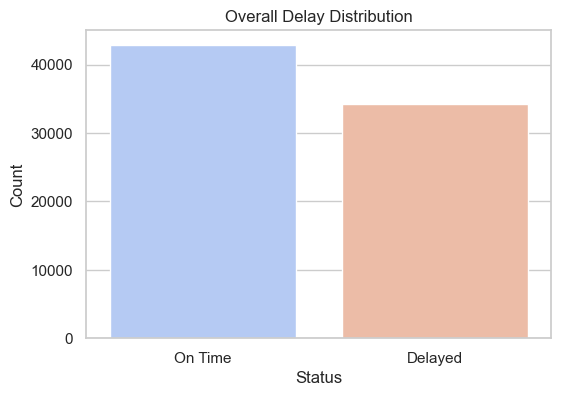

In [7]:
# Delay distribution( on time vs delayed)

delay_counts = df['has_delay'].value_counts()
delay_df = delay_counts.rename({0: "On Time", 1: "Delayed"}).reset_index()
delay_df.columns = ["Status", "Count"]

plt.figure(figsize=(6,4))
sns.barplot(
    data=delay_df,
    x="Status",
    y="Count",
    hue="Status",
    palette="coolwarm",
    legend=False
)
plt.title("Overall Delay Distribution")
plt.show()


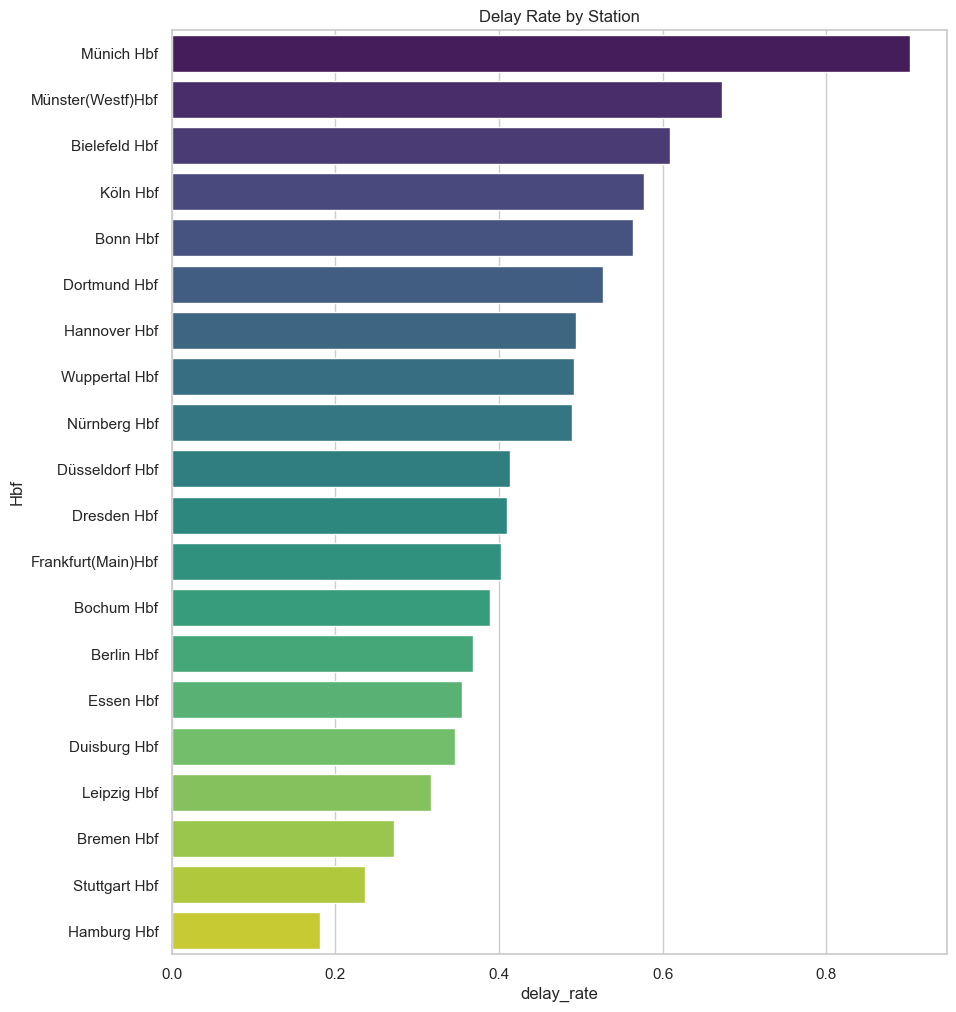

In [8]:
# Delay rate by Station(Hbf)

delay_by_station = df.groupby("Hbf")["has_delay"].mean().sort_values(ascending=False)
station_df = delay_by_station.reset_index()
station_df.columns = ["Hbf", "delay_rate"]

plt.figure(figsize=(10,12))
sns.barplot(
    data=station_df,
    x="delay_rate",
    y="Hbf",
    hue="Hbf",
    palette="viridis",
    legend=False
)
plt.title("Delay Rate by Station")
plt.show()


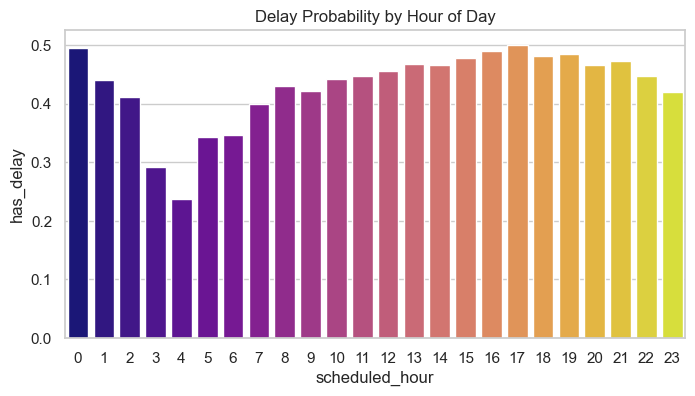

In [9]:
# Delay by Hour of the day

delay_by_hour = df.groupby("scheduled_hour")["has_delay"].mean().reset_index()

plt.figure(figsize=(8,4))
sns.barplot(
    data=delay_by_hour,
    x="scheduled_hour",
    y="has_delay",
    hue="scheduled_hour",
    palette="plasma",
    legend=False
)
plt.title("Delay Probability by Hour of Day")
plt.show()


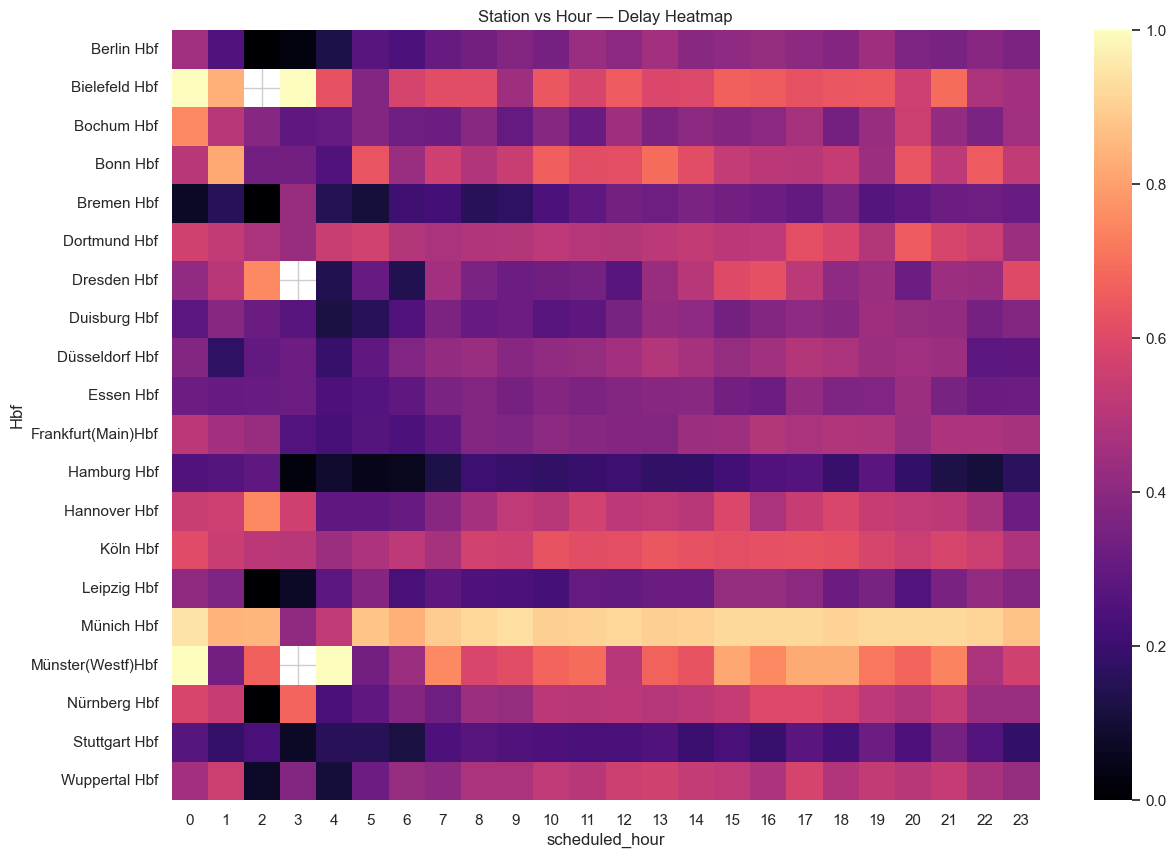

In [10]:
# Delay Heatmap

heatmap_data = df.pivot_table(
    values="has_delay",
    index="Hbf",
    columns="scheduled_hour",
    aggfunc="mean"
)

plt.figure(figsize=(14,10))
sns.heatmap(heatmap_data, cmap="magma")
plt.title("Station vs Hour — Delay Heatmap")
plt.show()


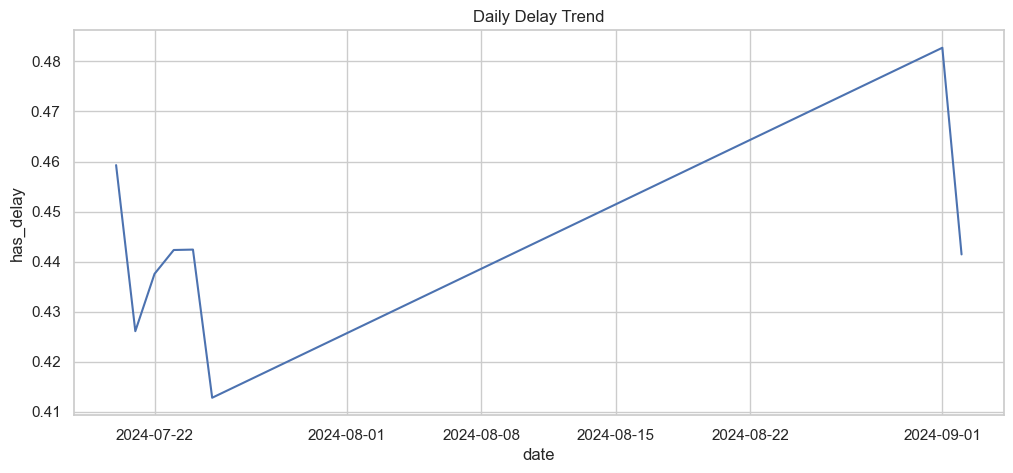

In [11]:
# Delay trend over time (Daily)

daily_delay = df.groupby("date")["has_delay"].mean().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(
    data=daily_delay,
    x="date",
    y="has_delay"
)
plt.title("Daily Delay Trend")
plt.show()


# Feature Engineering

In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [13]:
# Parse date & time columns safely 
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['scheduled_time'] = pd.to_datetime(df['scheduled_time'], format="%H:%M", errors='coerce')

In [14]:
# Create time-based features 
df['day_of_week'] = df['date'].dt.dayofweek        # 0 = Monday
df['month'] = df['date'].dt.month
df['scheduled_hour'] = df['scheduled_time'].dt.hour

In [15]:
# Clean the target variable (has_delay) 
df['has_delay'] = df['has_delay'].fillna(0).astype(int)

In [16]:
# Extract features from route (start & end station) 
df['route_start'] = df['route'].str.split(" - ").str[0]
df['route_end'] = df['route'].str.split(" - ").str[-1]

In [17]:
# Encode categorical features 
le = LabelEncoder()

df['train_model_encoded'] = le.fit_transform(df['train_model'].astype(str))
df['route_start_encoded'] = le.fit_transform(df['route_start'].astype(str))
df['route_end_encoded'] = le.fit_transform(df['route_end'].astype(str))

In [18]:
# Convert platform to numeric safely 
df['platform'] = pd.to_numeric(df['platform'], errors='coerce')



In [19]:
# Display updated dataframe 
df.head()

,date,Hbf,scheduled_time,expected_time,train_model,route,platform,real_time_due_to_delay,has_delay,scheduled_dt,expected_dt,scheduled_hour,delay_minutes,day_of_week,month,route_start,route_end,train_model_encoded,route_start_encoded,route_end_encoded
0,2024-09-01,Köln Hbf,1900-01-01 13:00:00,13:00,RE 8(10819),"Rommerskirchen, 13:00",3.0,13:00,0,1900-01-01 13:00:00,1900-01-01 13:00:00,13,0.0,6,9,"Rommerskirchen, 13:00","Rommerskirchen, 13:00",4156,27105,27735
1,2024-09-01,Hannover Hbf,1900-01-01 13:00:00,13:00,S 2,"Nienburg(Weser), 13:00",1.0,13:00,0,1900-01-01 13:00:00,1900-01-01 13:00:00,13,0.0,6,9,"Nienburg(Weser), 13:00","Nienburg(Weser), 13:00",5319,24661,25294
2,2024-09-01,Münster(Westf)Hbf,1900-01-01 13:00:00,13:00,RB 89(90018),"Paderborn Hbf, 13:00",3.0,13:00,0,1900-01-01 13:00:00,1900-01-01 13:00:00,13,0.0,6,9,"Paderborn Hbf, 13:00","Paderborn Hbf, 13:00",3185,25622,26248
3,2024-09-01,Hamburg Hbf,1900-01-01 13:01:00,13:01,S 5,"Hamburg Elbgaustraße, 13:01",NaN,13:01,0,1900-01-01 13:01:00,1900-01-01 13:01:00,13,0.0,6,9,"Hamburg Elbgaustraße, 13:01","Hamburg Elbgaustraße, 13:01",5322,12870,13172
4,2024-09-01,Frankfurt(Main)Hbf,1900-01-01 13:01:00,13:01,S 4,"Kronberg(Taunus), 13:01",NaN,13:01,0,1900-01-01 13:01:00,1900-01-01 13:01:00,13,0.0,6,9,"Kronberg(Taunus), 13:01","Kronberg(Taunus), 13:01",5321,17860,18252


# Train and Test Split + ML Models

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# Select features
features = [
    'day_of_week',
    'month',
    'scheduled_hour',
    'train_model_encoded',
    'route_start_encoded',
    'route_end_encoded',
    'platform'
]

X = df[features]
y= df['has_delay']


In [22]:
# Train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42, stratify=y
)

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_train.shape)

Shape of training data: (61716, 7)
Shape of test data: (61716, 7)


In [23]:
# Random forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("\n Random Forest Accuracy:" ,accuracy_score(y_test, pred_rf))
print("\nClassification Report (Random forest):")
print(classification_report(y_test, pred_rf))


 Random Forest Accuracy: 0.802851587815943

Classification Report (Random forest):
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      8579
           1       0.80      0.74      0.77      6851

    accuracy                           0.80     15430
   macro avg       0.80      0.80      0.80     15430
weighted avg       0.80      0.80      0.80     15430



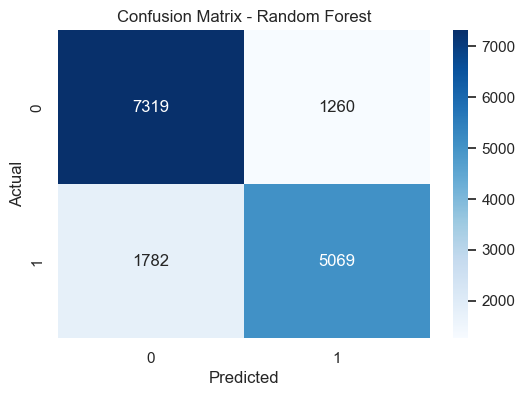

In [24]:
# Confusion Matrix(Random Forest)
cm = confusion_matrix(y_test, pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Model Improvement

In [25]:
# Hyperparameters tuning (Random Forest with GridSearch CV)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameters to try
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.8303519346684815


In [26]:
# Evaluate Tuned Model

best_rf = grid_search.best_estimator_
pred_tuned = best_rf.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score

print("Tuned Random Forest Accuracy:", accuracy_score(y_test, pred_tuned))
print(classification_report(y_test, pred_tuned))


Tuned Random Forest Accuracy: 0.840246273493195
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      8579
           1       0.82      0.81      0.82      6851

    accuracy                           0.84     15430
   macro avg       0.84      0.84      0.84     15430
weighted avg       0.84      0.84      0.84     15430



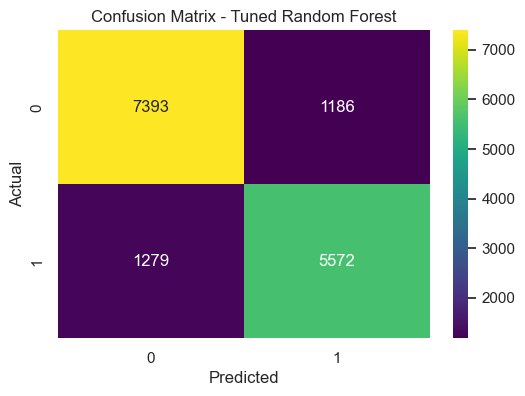

In [27]:
# Confusion Matrix for Tuned Model

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred_tuned)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


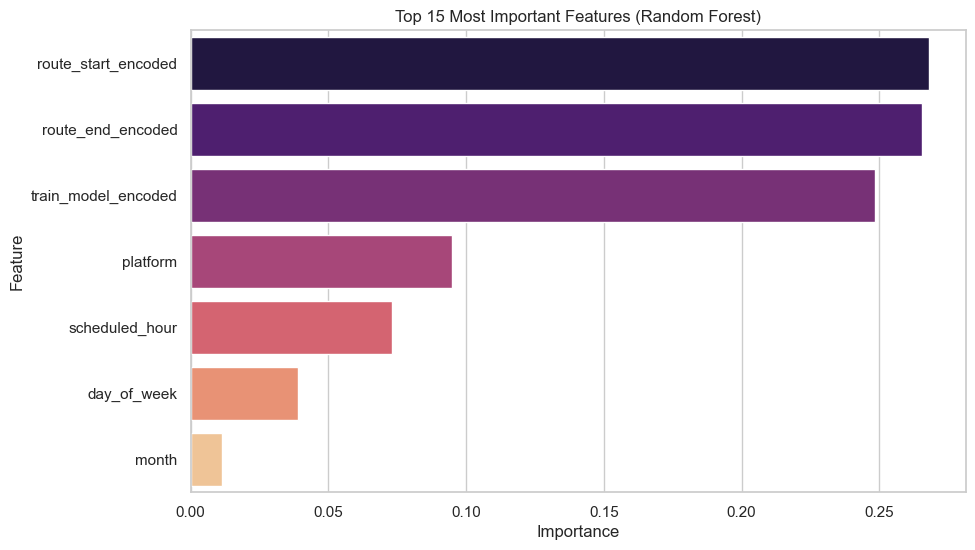

In [28]:
# Feature Importance Plot

import pandas as pd

feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(
    x=feature_importances.values,
    y=feature_importances.index,
    hue=feature_importances.index,  
    legend=False,                   
    palette="magma"
)
plt.title("Top 15 Most Important Features (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


# Model Evaluation

🔍 Model Evaluation Metrics
------------------------------
Accuracy:  0.8364
Precision: 0.8204
Recall:    0.8083
F1 Score:  0.8144


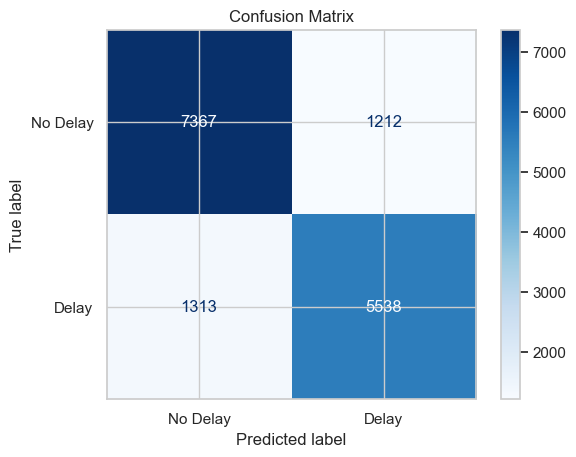

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

# Define model
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    max_depth=None
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("🔍 Model Evaluation Metrics")
print("------------------------------")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Delay", "Delay"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# Hperparameter Tuning (RandomisedSearchCV)

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Setup RandomizedSearch
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=25,         # number of parameter combinations to test
    cv=3,              # 3-fold cross validation
    verbose=2,
    n_jobs=-1          # use all CPU cores for speed
)

# Fit the search
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

print("Best Parameters Found:")
print(random_search.best_params_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Parameters Found:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}


# Evaluate the Tuned Model

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_best = best_model.predict(X_test)

print("Tuned Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1 Score:", f1_score(y_test, y_pred_best))


Tuned Model Performance:
Accuracy: 0.8484121840570318
Precision: 0.8368169602866528
Recall: 0.8181287403298788
F1 Score: 0.8273673333825374


# Saving trained Model

In [32]:
!pip install joblib

In [33]:
import joblib

# Save the trained model
joblib.dump(rf, "delay_prediction_model.pkl")

print("Model saved as delay_prediction_model.pkl")


Model saved as delay_prediction_model.pkl
